# Imputing missing values
We work with the data set how it is present now and apply a common machine learning methods to compute the imputations for missing values:

The **weighted k nearest neighbour (w-kNN)** algorithm, which imputes missing values with weights equal to the inverse Euclidean distance.

Assumptions: we believe the values missing lie in between the boundaries of the highest and lowest value present in the data set. This might work well for most, but it could also be that the missing values are outliers.



In [1]:
import numpy as np
import pandas as pd
import math
import os
import pickle
import copy
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from sklearn.preprocessing import scale

In [2]:
# loading original and standardised data set
dict_all = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dict_all_wb.pkl', 'rb'))
dict_all_std = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dict_all_wb_std.pkl', 'rb'))

In [3]:
# check
print('Original values: ')
print(dict_all['Belgium'].loc['ER.H2O.FWTL.ZS'])

print('--------')

print('Standardised values: ')
print(dict_all_std['Belgium'].loc['ER.H2O.FWTL.ZS'])

Original values: 
1990          NaN
1991          NaN
1992          NaN
1993          NaN
1994          NaN
1995          NaN
1996          NaN
1997    64.083333
1998          NaN
1999          NaN
2000          NaN
2001          NaN
2002    56.125000
2003          NaN
2004          NaN
2005          NaN
2006          NaN
2007    51.783333
2008          NaN
2009          NaN
2010          NaN
2011          NaN
2012    50.016667
2013          NaN
2014          NaN
2015          NaN
2016          NaN
2017          NaN
2018          NaN
2019          NaN
Name: ER.H2O.FWTL.ZS, dtype: float64
--------
Standardised values: 
1990         NaN
1991         NaN
1992         NaN
1993         NaN
1994         NaN
1995         NaN
1996         NaN
1997    1.580306
1998         NaN
1999         NaN
2000         NaN
2001         NaN
2002    0.114715
2003         NaN
2004         NaN
2005         NaN
2006         NaN
2007   -0.684838
2008         NaN
2009         NaN
2010         NaN
2011         NaN


In [4]:
# number of values
s = 0
for country in dict_all_std.keys():
    s += np.sum(dict_all_std[country].count())

print(s)

852036


## 1) weighted k nearest neighbour (w-kNN)
The w-kNN algorithm is straightforward: we calculate how similar countries are in each given year $y$ with the standardised Euclidean distance $E_y$ and take the inverse of the absolute $|E_y|$ as the weight to impute missing values in any given country $c_i$ in each given year $y$ for each given sub-indicator $j$.

### Euclidean distance
The Euclidean distance $e_y$ for year $y$ for any given pair of countries $(c_i, c_k)$ for any given sub-indicator $j$ is calculated by:$$ e_y(c_{i}, c_{k}) = \lVert c_{i}, c_{k} \rVert_2 = \sqrt{ \sum_{j=1}^J(c_{ij} - c_{kj})^2} $$

We calculate the squared distances between any given pair of countries $(c_i, c_k)$, but do not consider the country $k+1$ which has the largest distance $e_y$ to country $i$. We do so for any given sub-indicator $j$ and take the square root of it. $c_{ij}$ is the sub-indicator $j$ of country $i$, and $i \neq k$. Thus, any unique pair of countries $i$ and $k$, $i \neq k$, has one Euclidean distance $e_y$ for year $y$ only.

Afterwards, we normalise this with respect to the country $k+1$ which has the largest distance $e_y$ to country $i$ by the following equation:

$$ E_y(c_{i}, c_{k}) = \frac{e_y(c_{i}, c_{k})}{e_y(c_{i}, c_{k+1})} $$
This can be seen as equivalent to the well-known normalisation equation:

$$
x_n = \frac{x - x_{min}}{x_{max}-x_{min}}
$$
since $x_{min}$ is always 0, because the distance "between" the same country is 0.

### Imputations
We want that our imputations $x^{j}_{i,y}$ for missing sub-indicator $j$ in country $i$ in year $y$ are similar to sub-indicators $j$ of countries $k$ which have a small Euclidean distance $E_y$ and dissimilar to sub-indicators $j$ of countries $k$ which have a large Euclidean distance $E_y$. Consequently, the imputations $x^{j}_{i,y}$ are the weighted averages where the weights are equal to the inverse standardised Euclidean distance $\frac{1}{|E_y(c_{i}, c_{k})|}$.

First, we compute $E_y$ for all available pairs of sub-indicators $j$ amongst two countries $i$ and $k$. Since countries have different amounts of available data points, we average by multiplying the sum by $1/J$, where $J$ is the total number of sub-indicators taken into account here. Note, this does not necessarily be 375, because we have missing values for many sub-indicators. Second, we sum over $k$ to add together all weighted $x^j_{k,y}$ of each unique pair of countries $i$ and $k$ and compute its average by dividing by $K$.

$$ x^{j}_{i,y} = \frac{1}{K} \sum_k \frac{1}{|E_y(c_{i}, c_{k})|} \cdot x^j_{k,y} $$

**Assumptions:** we calculate how similar countries are according to their values for all sub-indicators in a given year. We assume that the specific sub-indicators which do not have values in this given year are exactly as similar as the ones which we can calculate a distance for.

### Calculating the Euclidean distance
We can calculate the standardised distance $E_y(c_{i}, c_{k})$ after having prepared everything. We do this for each unique pair of two countries in each year. In other words, we do not want to calculate $E_y(c_{i}, c_{k})$ for $i = k$ and $E_y(c_{i}, c_{k}) = E_y(c_{k}, c_{i})$.

The python package itertools can help us generating the unique pairs of countries.

In [5]:
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])

In [6]:
# create list out of all unique combinations
countrycombinations = list(itertools.combinations(countries, 2))
countrycombinations

[('Afghanistan', 'Albania'),
 ('Afghanistan', 'Algeria'),
 ('Afghanistan', 'Angola'),
 ('Afghanistan', 'Antigua and Barbuda'),
 ('Afghanistan', 'Argentina'),
 ('Afghanistan', 'Armenia'),
 ('Afghanistan', 'Australia'),
 ('Afghanistan', 'Austria'),
 ('Afghanistan', 'Azerbaijan'),
 ('Afghanistan', 'Bahamas, The'),
 ('Afghanistan', 'Bahrain'),
 ('Afghanistan', 'Bangladesh'),
 ('Afghanistan', 'Barbados'),
 ('Afghanistan', 'Belarus'),
 ('Afghanistan', 'Belgium'),
 ('Afghanistan', 'Belize'),
 ('Afghanistan', 'Benin'),
 ('Afghanistan', 'Bhutan'),
 ('Afghanistan', 'Bolivia'),
 ('Afghanistan', 'Bosnia and Herzegovina'),
 ('Afghanistan', 'Botswana'),
 ('Afghanistan', 'Brazil'),
 ('Afghanistan', 'Brunei Darussalam'),
 ('Afghanistan', 'Bulgaria'),
 ('Afghanistan', 'Burkina Faso'),
 ('Afghanistan', 'Burundi'),
 ('Afghanistan', 'Cambodia'),
 ('Afghanistan', 'Cameroon'),
 ('Afghanistan', 'Canada'),
 ('Afghanistan', 'Central African Republic'),
 ('Afghanistan', 'Chad'),
 ('Afghanistan', 'Chile'),
 ('Af

Here, we calculate the standardised distance $E_y(c_{i}, c_{k})$ for each unique pair of two countries in each year.


In [7]:
from scipy.spatial import distance

First, we compute the (not standardised) distances $e_y$ and insert them into a new dictionary dict_e.

While exploring the data, we see that nearly no data are available for the years 1990 to 1999. Consequently, imputations in those years will be based on very weak foundations and we do not consider these years for now. For our similarity investigations later, it does not matter much how many data points we have totally available per country, it is more important that all countries have the same amount of data points. For now, we also omit data for the year 2019, because it seems not all countries have reported their data yet. Hence, there aren't too many data points available neither.

We set the period of years we want to consider in our computations for $e_y$.

In [8]:
period = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
          '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [9]:
# call seriescodes again
info = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None, dtype=str)
info.drop_duplicates(subset=[2], inplace=True)
#seriescodes = list(info['Series Code'])
seriescodes = list(dict_all['Germany'].index)
print(len(seriescodes))
print(len(info))

400
400


In [10]:
# finding which seriescodes are not in other list 
for seriescode in seriescodes:
    if seriescode not in list(info[0]):
        print(seriescode)

print('-------')

for seriescode in list(info[0]):
    if seriescode not in seriescodes:
        print(seriescode)

SG_DSR_LGRGSR
-------
Temperature


#### Comparing Euclidean distances computed with vectors of different dimensions
Simply computing the Euclidean distance between all the countries we have won't give us the results we like, because each of the pairs of countries we calculate the Euclidean distance for has different many measurements to take into account.

We consider this by counting how many measurements j we have for each pair of countries and setting the weight w as the invesre of the number of measurements.

In [11]:
# ~ one hour computing time
# no need to run every time again, just see CHECKPOINT above and load pickle file

dict_e = {}    

for year in period:
    print(year)
    
    for countrycombination in countrycombinations:
        
        country0_e = []    # create two empty lists for the two groupings we consider at the moment
        country1_e = []    # these lists contain series codes with data available in both groupings
        j = 0    # counter
        
        for seriescode in seriescodes:
            # we can only consider sub-indicators with data available in both groupings
            if pd.isna(dict_all_std[countrycombination[0]].loc[seriescode, year]) is False and pd.isna(dict_all_std[countrycombination[1]].loc[seriescode, year]) is False:
                country0_e.append(dict_all_std[countrycombination[0]].loc[seriescode, year])
                country1_e.append(dict_all_std[countrycombination[1]].loc[seriescode, year])
                
                j += 1
        
        #print('number of data points available: ', j)    # check
        if j > 0:
            e = distance.euclidean(country0_e, country1_e, w=1/j)
        else:
            e = np.nan    # make NaN
            
        #print('e in {} between {} and {}:'.format(year, countrycombination[0], countrycombination[1]), e)
        
        dict_e[year, countrycombination[1], countrycombination[0]] = e
        dict_e[year, countrycombination[0], countrycombination[1]] = dict_e[year, countrycombination[1], countrycombination[0]]

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [12]:
# better save these precious data
f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/distances_unstd.pkl', 'wb')
pickle.dump(dict_e, f)
f.close()


In [13]:
# CHECKPOINT
dict_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/distances_unstd.pkl', 'rb'))

In [13]:
# check
print(dict_e['2011', 'Switzerland', 'Iraq'])

0.8072662133278651


Normalise these distances $e_y$ and save them in dict_E:

In [14]:
dict_E = {}

for year in period:
    print(year)
    
    max_e = 0    # maximum value per year
    min_e = 0
    dict_e_year = {}    # auxiliary dictionary with all distances per year
    
    for k in dict_e.keys():
        if year in k:
            dict_e_year[k] = dict_e[k]            

    max_e = np.nanmax(list(dict_e_year.values()))

    #print('------------')
    #print('max_e in {}'.format(year), max_e)
    #print('------------')
       
    for k in dict_e_year.keys():
        #print(k)
        if np.isnan(dict_e_year[k]) == False:
            #print('unstandardised distance e:', dict_e_year[k])
            dict_E[k] = dict_e_year[k] / max_e    # standardise distance
            
        else:
            dict_E[k] = np.nan    # keep as NaN
        
        #print('standardised distance E:', dict_E[k])
        #print('------------')


2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [15]:
# check
print('unstandardised distance e:', dict_e['2016', 'Afghanistan', 'Colombia'])
print('standardised distance E:  ', dict_E['2016', 'Afghanistan', 'Colombia'])

unstandardised distance e: 1.0780052237179805
standardised distance E:   0.5166271596570462


In [16]:
# check (both should be False)
print(0 in dict_e.values())
print(0 in dict_E.values())

False
False


In [17]:
# check 
min_value = 0.1

for key, value in dict_E.items():
    if 0 < value < min_value:
        min_value = value
        print('smallest:', key, value)

In [18]:
# better save these precious data
f = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/distances_std.pkl', 'wb')
pickle.dump(dict_E, f)
f.close()

### Imputations for countries
Now, we impute the missing values according to the equation we previously derived:

$$ x^{j'}_{i,y} = \frac{1}{K} \sum_k \frac{1}{|E_y(c_{i}, c_{k})|} \cdot x^j_{k,y} $$
To recap, our imputations $x^{j'}_{i,y}$ for missing sub-indicator $j'$ in country $i$ in year $y$ should be similar to sub-indicators $j$ of country $k$, according to the inverse standardised Euclidean distance $\frac{1}{|E_y(c_{i}, c_{k})|}$ between $i$ and $k$.

As aforementioned and shown in the equation of $E_y$, $E_y$ is dependent on the number of pairs we have in both countries data for. Our dict_E has already entries for $E$ normalised according to this number of available pairs of data. We multiply our weight for each imputation, i.e. the inverse standardised Euclidean distance $\frac{1}{|E_y(c_{i}, c_{k})|}$ between $i$ and $k$, by the value $x^j_{k,y}$ of the other country $k$ in year $y$ for sub-indicator $j$. We sum over $k$ to add together all weighted $x^j_{k,y}$ of each unique pair of countries $i$ and $k$ and compute its average by dividing by $K$. $K$ is the number of countries which have values available for the sub-indicator $x^{j'}_{k,y}$ to be computed.



In [19]:
# ~30 minutes

dict_all_i = {}

for country in tqdm(countries):
    
    dict_all_i[country] = pd.DataFrame(index=seriescodes, columns=period)
    
    not_countries = [c for c in countries if c != country]
    
    for seriescode in seriescodes:
        for year in period:            
            if pd.isna(dict_all_std[country].loc[seriescode, year]) is True:
                K = 0
                all_k = []
                
                for not_country in not_countries: 
                    if pd.isna(dict_all_std[not_country].loc[seriescode, year]) is False and pd.isna(dict_E[(year, country, not_country)]) is False: # and dict_E[(year, country, not_country)]!=0:    # not_country can also have NaN -> exclude those
                        K += 1
                        # print('value:', dict_all_std[not_country].loc[seriescode, year])
                        # print('distance:', dict_E[(year, country, not_country)])
                        k = (dict_all_std[not_country].loc[seriescode, year]) / (dict_E[(year, country, not_country)])
                        # print('k =', k)
                        all_k.append(k)
                        
                sum_k = np.sum(all_k)
                    
                #print('K =', K)
                    
                if K > 0:
                    # print('sum k =', sum_k)
                    
                    dict_all_i[country].loc[seriescode, year] = sum_k / K
                            
                else:
                    dict_all_i[country].loc[seriescode, year] = np.nan    # only impute when data of other countries is available, 0 cannot be imputed because time-series are non-stationary
                
                #print('Imputation for {} in {} in {}'.format(seriescode, country, year), dict_all_i[country].loc[seriescode, year])        
                
            else:
                dict_all_i[country].loc[seriescode, year] = dict_all_std[country].loc[seriescode, year]

  0%|          | 0/181 [00:00<?, ?it/s]

We need to delete all keys which are not part of the list of countries.

In [20]:
delete_keys = []

for key in dict_all_i.keys():
    if key not in countries:
        delete_keys.append(key)
        
# delete
for dk in delete_keys:
    dict_all_i.pop(dk, None)

In [21]:
delete_keys

[]

In [22]:
# check 
max_values = []

for c in dict_all_i.keys():
    max_values.append(dict_all_i[c].max().max())
    
max(max_values)

9.441663613083346

In [23]:
# check
print('NaN here', dict_all_std['Afghanistan'].loc['SE.SEC.UNER.LO.ZS', '2016'])
print('Imputed value', dict_all_i['Afghanistan'].loc['SE.SEC.UNER.LO.ZS', '2016'])

NaN here nan
Imputed value -0.4683947162651347


In [24]:
# check
dict_all_i['Afghanistan'].loc['SE.SEC.UNER.LO.ZS']

2000     0.707525
2001     0.815221
2002     0.090005
2003    0.0141494
2004    -0.338782
2005    -0.390047
2006    -0.322103
2007    -0.282218
2008    -0.178068
2009    0.0878353
2010   -0.0817098
2011    -0.186811
2012    -0.279201
2013     -0.39546
2014    -0.461868
2015    -0.944018
2016    -0.468395
2017    -0.484696
2018    -0.781181
2019     -3.02535
Name: SE.SEC.UNER.LO.ZS, dtype: object

We want to save the imputations to have another checkpoint here.

In [25]:
for c in countries:
    dict_all_i[c].to_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/csv_imputed/{}_wb.csv'.format(c))
    
# as pkl files
imp = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dict_all_i_wb.pkl', 'wb')
pickle.dump(dict_all_i, imp)
imp.close()

In [ ]:
# CHECKPOINT
dict_all_i = pickle.load(open('utils/Data/dict_all_i_wb.pkl', 'rb'))

Let's calculate the total number of values:

## (WorldBank data set) Concatenating indicator data to target-level

We concatenate indicator data to target-level. 
1. We can average all series codes, i.e. indicators, belonging to one target to this target.
2. We can see the series codes as multiple samples of the same target and concatenate the series codes into tarjets. Consequently, we have more than one measurement per time point for any tarjet having more than one series code.


In [27]:
# check
dict_all_std['Afghanistan']

TimePeriod,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.279600,0.506205,0.746543,1.033575,1.283527,1.573306,1.894672,NaN,NaN,NaN
EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.695603,-0.675679,0.312007,0.305643,1.090614,0.403608,1.403584,1.403584,1.442255,NaN
EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.686047,-0.706401,0.279194,0.292840,1.087533,0.396553,1.421530,1.421297,1.458510,NaN
EG.ELC.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.896915,-0.423962,0.634500,0.342497,1.098945,0.320685,1.199366,1.199366,1.262129,NaN
FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.884230,NaN,NaN,-0.513711,NaN,NaN,1.397941,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VC_DSR_MTMN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,1.000000
VC_DSR_MTMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,1.000000
VC_DSR_PDAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.737766,-0.675998,1.413764
VC_DSR_PDLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,1.000000,NaN


In [28]:
# making all time-series "pointing" upwards when they are meant to increase
# not necessary when computing non-linear dependence

indicators_values_i_up = {}
indicators_values_std_up = {}

for country in countries:
    indicators_values_i_up[country] = pd.DataFrame(index=list(dict_all_i[country].index), columns=period)
    indicators_values_std_up[country] = pd.DataFrame(index=list(dict_all_std[country].index), columns=period)
    
    for seriescode in list(dict_all_std['France'].index):
        #indicators_values_i_up[country].at[seriescode] = list(np.multiply(list(dict_all_i[country].loc[seriescode]), int(info.loc[info[0] == seriescode][5])))
        # leaving them as they are to investigate dependencies between indicators (direction does not matter then)
        indicators_values_i_up[country].at[seriescode] = list(dict_all_i[country].loc[seriescode])
        indicators_values_std_up[country].at[seriescode] = list(dict_all_std[country].loc[seriescode][period])

In [33]:
#CHECK MISSIG VALUES AT THE BEGINNING AND HOW MANY WERE IMPUTED FOR PERIOD 2000-2019
# number of values initially
s_init = 0
for country in indicators_values_std_up.keys():
    s_init += np.sum(indicators_values_std_up[country].count())

# number of values after imputation
s_imp = 0
for country in indicators_values_i_up.keys():
    s_imp += np.sum(indicators_values_i_up[country].count())

print('Total # values before imputations:', s_init)
print('Total # values after imputations:', s_imp)
print('How many have been imputed?', s_imp - s_init)
print('This accounts for', round(100*(s_imp-s_init)/s_imp, 2), '% of the total data available now')    
total = 20*180*400
print("Total # values we should have:", total)    
print("Initially we had", round(100*s_init/total,2), "% of the total measurements")
print("Now we have", round(100*s_imp/total,2), "% of the total measurements")

Total # values before imputations: 641289
Total # values after imputations: 1178310
How many have been imputed? 537021
This accounts for 45.58 % of the total data available now
Total # values we should have: 1440000
Initially we had 44.53 % of the total measurements
Now we have 81.83 % of the total measurements


In [35]:
# check 
dict_all_std['France'].loc['ER.H2O.FWTL.ZS']

TimePeriod
1990         NaN
1991         NaN
1992    2.156921
1993         NaN
1994         NaN
1995         NaN
1996         NaN
1997   -0.531284
1998         NaN
1999         NaN
2000         NaN
2001         NaN
2002    0.083250
2003         NaN
2004         NaN
2005         NaN
2006         NaN
2007   -0.331485
2008         NaN
2009         NaN
2010         NaN
2011         NaN
2012   -0.688701
2013         NaN
2014   -0.688701
2015         NaN
2016         NaN
2017         NaN
2018         NaN
2019         NaN
Name: ER.H2O.FWTL.ZS, dtype: float64

In [36]:
# check
indicators_values_std_up['France'].loc['ER.H2O.FWTL.ZS']

2000          NaN
2001          NaN
2002    0.0832496
2003          NaN
2004          NaN
2005          NaN
2006          NaN
2007    -0.331485
2008          NaN
2009          NaN
2010          NaN
2011          NaN
2012    -0.688701
2013          NaN
2014    -0.688701
2015          NaN
2016          NaN
2017          NaN
2018          NaN
2019          NaN
Name: ER.H2O.FWTL.ZS, dtype: object

In [37]:
# better save these precious data
ind_val_i = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/indicators_values_i_up_wb.pkl', 'wb')
pickle.dump(indicators_values_i_up, ind_val_i)
ind_val_i.close()

ind_val_std = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/indicators_values_std_up_wb.pkl', 'wb')
pickle.dump(indicators_values_std_up, ind_val_std)
ind_val_std.close()

In [38]:
targets = list(info[4].unique())
targets.remove('T')

dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [39]:
# check
dict_targets['13.1']

['EN.CLC.MDAT.ZS',
 'SG_DSR_SILN',
 'SG_DSR_SILS',
 'SG_GOV_LOGV',
 'VC_DSR_AFFCT',
 'VC_DSR_DAFF',
 'VC_DSR_IJILN',
 'VC_DSR_MISS',
 'VC_DSR_MORT',
 'VC_DSR_MTMN',
 'VC_DSR_MTMP',
 'VC_DSR_PDAN',
 'VC_DSR_PDLN',
 'VC_DSR_PDYN']

In [40]:
indicators_values_std_up['Germany']

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
EG.CFT.ACCS.ZS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
EG.ELC.ACCS.ZS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
EG.ELC.ACCS.RU.ZS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
EG.ELC.ACCS.UR.ZS,0.435264,-0.12284,-0.873248,-1.51735,-1.94323,-2.08537,-1.97205,-1.65538,-1.1873,-0.619743,-0.0299162,0.434609,0.695226,0.779821,0.791425,0.791425,0.791425,0.791425,0.791425,NaN
FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.31145,NaN,NaN,0.1974,NaN,NaN,1.11406,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VC_DSR_MTMP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VC_DSR_IJILN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VC_DSR_AFFCT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VC_DSR_PDAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# with imputed values

targets_values_i_up = {}
targets_values_i_up_arr = {}
targets_values_i_up_avg = {}

for country in tqdm(countries):
    targets_values_i_up_arr[country] = []
    targets_values_i_up_avg[country] = pd.DataFrame(index=targets, columns=period)
    
    for t, target in enumerate(list(dict_targets.keys())):
        list_indicators_values_i_up_arr = []

        for y, year in enumerate(period):
            list_indicators_values_i_up_avg = []
            for i, indicator in enumerate(list(dict_targets[target])):
                # do not append NaNs                  
                if np.isnan(indicators_values_i_up[country].loc[indicator, year])==False:
                    list_indicators_values_i_up_arr.append(indicators_values_i_up[country].loc[indicator, year])
                    list_indicators_values_i_up_avg.append(indicators_values_i_up[country].loc[indicator, year])
            
            # 1. averaging
            targets_values_i_up_avg[country].loc[target, year] = np.mean(list_indicators_values_i_up_avg)

        # 2. concatenating
        targets_values_i_up_arr[country].append(list_indicators_values_i_up_arr)
    
    targets_values_i_up[country] = pd.DataFrame(data=targets_values_i_up_arr[country], index=list(dict_targets.keys()))

  0%|          | 0/181 [00:00<?, ?it/s]

In [44]:
# with standardised values

targets_values_std_up = {}
targets_values_std_up_arr = {}
targets_values_std_up_avg = {}

for country in tqdm(countries):
    targets_values_std_up_arr[country] = []
    targets_values_std_up_avg[country] = pd.DataFrame(index=targets, columns=period)
    
    for t, target in enumerate(list(dict_targets.keys())):
        list_indicators_values_std_up_arr = []

        for y, year in enumerate(period):
            list_indicators_values_std_up_avg = []
            for i, indicator in enumerate(list(dict_targets[target])):
                # do not append NaNs                  
                if np.isnan(indicators_values_std_up[country].loc[indicator, year])==False:
                    list_indicators_values_std_up_arr.append(indicators_values_std_up[country].loc[indicator, year])
                    list_indicators_values_std_up_avg.append(indicators_values_std_up[country].loc[indicator, year])
            
            # 1. averaging
            targets_values_std_up_avg[country].loc[target, year] = np.mean(list_indicators_values_std_up_avg)

        # 2. concatenating
        targets_values_std_up_arr[country].append(list_indicators_values_std_up_arr)
    
    targets_values_std_up[country] = pd.DataFrame(data=targets_values_std_up_arr[country], index=list(dict_targets.keys()))

  0%|          | 0/181 [00:00<?, ?it/s]

In [42]:
# check whether averages were correctly computed
print(targets_values_i_up_avg['France'].loc['2.1', '2017'])
print(np.mean(indicators_values_i_up['France'].loc[info[info[4]=='2.1'][0]]['2017']))

0.09029942622019882
0.09029942622019882


In [47]:
# check for std
for t, target in enumerate(targets):
    print(target, len(targets_values_std_up_arr['Azerbaijan'][t]))

1.3 18
1.1 5
1.2 7
2.3 18
2.2 71
2.1 29
3.5 6
3.3 136
3.2 80
3.4 30
3.7 21
3.8 48
3.c 30
3.a 18
3.9 19
3.1 35
3.6 2
4.6 70
4.1 371
4.5 34
4.2 76
4.c 163
4.4 167
4.3 39
5.5 24
5.6 0
5.1 22
5.4 42
5.2 1
5.3 4
6.4 26
6.1 72
6.2 130
7.1 74
7.3 16
7.2 32
8.1 79
8.3 11
8.2 260
8.5 282
8.7 6
8.6 0
9.4 68
9.5 19
9.1 74
9.2 40
9.b 19
10.b 38
10.2 0
10.c 7
10.1 0
11.6 50
11.1 60
12.2 133
13.2 0
13.1 1
14.4 51
14.5 3
15.1 40
15.5 4
16.6 13
16.5 6
16.9 5
16.1 40
17.3 60
17.2 19
17.4 19
17.1 22
17.17 2
17.6 32
17.19 48
17.18 16
17.8 17
17.11 20
17.13 447
17.12 60


In [48]:
# check for i
for t, target in enumerate(targets):
    print(target, len(targets_values_i_up_arr['Azerbaijan'][t]))

1.3 336
1.1 19
1.2 92
2.3 18
2.2 317
2.1 45
3.5 6
3.3 138
3.2 80
3.4 30
3.7 38
3.8 78
3.c 38
3.a 18
3.9 19
3.1 37
3.6 2
4.6 133
4.1 420
4.5 80
4.2 80
4.c 420
4.4 376
4.3 60
5.5 69
5.6 13
5.1 25
5.4 76
5.2 14
5.3 57
6.4 97
6.1 108
6.2 216
7.1 74
7.3 16
7.2 32
8.1 82
8.3 73
8.2 260
8.5 300
8.7 51
8.6 60
9.4 68
9.5 38
9.1 76
9.2 40
9.b 19
10.b 38
10.2 1
10.c 14
10.1 8
11.6 50
11.1 65
12.2 133
13.2 1
13.1 166
14.4 51
14.5 3
15.1 40
15.5 4
16.6 16
16.5 32
16.9 89
16.1 76
17.3 60
17.2 19
17.4 19
17.1 40
17.17 60
17.6 38
17.19 48
17.18 16
17.8 20
17.11 20
17.13 520
17.12 114


In [49]:
# better save these precious imputed data
tar_val_i_up = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_wb.pkl', 'wb')
pickle.dump(targets_values_i_up, tar_val_i_up)
tar_val_i_up.close()

tar_val_i_up_arr = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'wb')
pickle.dump(targets_values_i_up_arr, tar_val_i_up_arr)
tar_val_i_up_arr.close()

tar_val_i_up_avg = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_avg_wb.pkl', 'wb')
pickle.dump(targets_values_i_up_avg, tar_val_i_up_avg)
tar_val_i_up_avg.close()

In [50]:
# better save these precious standardised data
tar_val_std_up = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_std_up_wb.pkl', 'wb')
pickle.dump(targets_values_std_up, tar_val_std_up)
tar_val_std_up.close()

tar_val_std_up_arr = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_std_up_arr_wb.pkl', 'wb')
pickle.dump(targets_values_std_up_arr, tar_val_std_up_arr)
tar_val_std_up_arr.close()

tar_val_std_up_avg = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_std_up_avg_wb.pkl', 'wb')
pickle.dump(targets_values_std_up_avg, tar_val_std_up_avg)
tar_val_std_up_avg.close()

## (WorldBank data set) Concatenating target data to goal-level
Defining dictionaries for goals.

In [51]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

In [52]:
# check
dict_goals['1']

['1.2', '1.3', '1.1']

Concatenating:

Recall that we define our dimensionality as $d \times T$, and countries are independent samples. We do this in the next cell exemplarily by appending the years for all indicators of SDG 1 to a list.

In [55]:
# example with SDG 1
len([x for x in list(targets_values_i_up[country].loc['1.1']) if str(x) != 'nan']) + 
len([x for x in list(targets_values_i_up[country].loc['1.2']) if str(x) != 'nan']) + 
len([x for x in list(targets_values_i_up[country].loc['1.3']) if str(x) != 'nan'])

447

In [56]:
goals_values_i_up = {}
goals_values_i_up_arr = {}
goals_values_i_up_avg = {}

for country in tqdm(countries):
    goals_values_i_up_arr[country] = []
    goals_values_i_up_avg[country] = []   # define this list with target values being averages over indicators
    
    for g, goal in enumerate(list(dict_goals.keys())):
        list_targets_values_i_up = []
        list_targets_values_i_up_avg = []

        for t in dict_goals[goal]:   # do not append NaN's
            list_targets_values_i_up.extend([x for x in list(targets_values_i_up[country].loc[t]) if np.isnan(x)==False])
            list_targets_values_i_up_avg.extend([x for x in list(targets_values_i_up_avg[country].loc[t]) if np.isnan(x)==False])
            
        # 1. append target averages
        goals_values_i_up_avg[country].append(np.asarray(list_targets_values_i_up_avg))

        # 2. concatenating
        goals_values_i_up_arr[country].append(np.asarray(list_targets_values_i_up))
    
    goals_values_i_up_avg[country] = np.asarray(goals_values_i_up_avg[country])
    goals_values_i_up[country] = pd.DataFrame(data=goals_values_i_up_arr[country], index=list(dict_goals.keys()))

  0%|          | 0/181 [00:00<?, ?it/s]

In [57]:
goals_values_std_up = {}
goals_values_std_up_arr = {}
goals_values_std_up_avg = {}

for country in tqdm(countries):
    goals_values_std_up_arr[country] = []
    goals_values_std_up_avg[country] = []   # define this list with target values being averages over indicators
    
    for g, goal in enumerate(list(dict_goals.keys())):
        list_targets_values_std_up = []
        list_targets_values_std_up_avg = []

        for t in dict_goals[goal]:   # do not append NaN's
            list_targets_values_std_up.extend([x for x in list(targets_values_std_up[country].loc[t]) if np.isnan(x)==False])
            list_targets_values_std_up_avg.extend([x for x in list(targets_values_std_up_avg[country].loc[t]) if np.isnan(x)==False])
            
        # 1. append target averages
        goals_values_std_up_avg[country].append(np.asarray(list_targets_values_std_up_avg))

        # 2. concatenating
        goals_values_std_up_arr[country].append(np.asarray(list_targets_values_std_up))
    
    goals_values_std_up_avg[country] = np.asarray(goals_values_std_up_avg[country])
    goals_values_std_up[country] = pd.DataFrame(data=goals_values_std_up_arr[country], index=list(dict_goals.keys()))

  0%|          | 0/181 [00:00<?, ?it/s]

In [58]:
# concatenating target averages
goals_values_std_up_avg['France'].shape

(17,)

In [59]:
# check for std
for g, goal in enumerate(list(dict_goals.keys())):
    print(goal, len(goals_values_std_up_arr['Mozambique'][g]))

1 39
2 140
3 414
4 715
5 96
6 227
7 120
8 516
9 195
10 45
11 115
12 128
13 114
14 54
15 44
16 39
17 855


In [60]:
# check for i
for g, goal in enumerate(list(dict_goals.keys())):
    print(goal, len(goals_values_i_up_arr['France'][g]))


1 447
2 380
3 484
4 1569
5 254
6 421
7 122
8 826
9 241
10 61
11 115
12 133
13 167
14 54
15 44
16 213
17 974


In [61]:
# better save these precious imputed data
goa_val_i_up = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_wb.pkl', 'wb')
pickle.dump(goals_values_i_up, goa_val_i_up)
goa_val_i_up.close()

goa_val_i_up_arr = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'wb')
pickle.dump(goals_values_i_up_arr, goa_val_i_up_arr)
goa_val_i_up_arr.close()

goa_val_i_up_avg = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_avg_wb.pkl', 'wb')
pickle.dump(goals_values_i_up_avg, goa_val_i_up_avg)
goa_val_i_up_avg.close()

# better save these precious standardised data
goa_val_std_up = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_std_up_wb.pkl', 'wb')
pickle.dump(goals_values_std_up, goa_val_std_up)
goa_val_std_up.close()

goa_val_std_up_arr = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_std_up_arr_wb.pkl', 'wb')
pickle.dump(goals_values_std_up_arr, goa_val_std_up_arr)
goa_val_std_up_arr.close()

goa_val_std_up_avg = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_std_up_avg_wb.pkl', 'wb')
pickle.dump(goals_values_std_up_avg, goa_val_std_up_avg)
goa_val_std_up_avg.close()

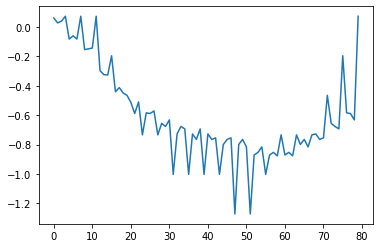

In [65]:
plt.plot(targets_values_i_up['France'].loc['3.2'])
plt.show()

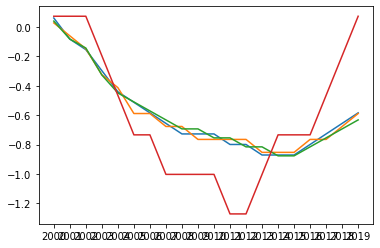

In [70]:
plt.plot(indicators_values_i_up['France'].loc['SH.DYN.MORT'])
plt.plot(indicators_values_i_up['France'].loc['SH.DYN.MORT.FE'])
plt.plot(indicators_values_i_up['France'].loc['SH.DYN.MORT.MA'])
plt.plot(indicators_values_i_up['France'].loc['SH.DYN.NMRT'])
plt.show()

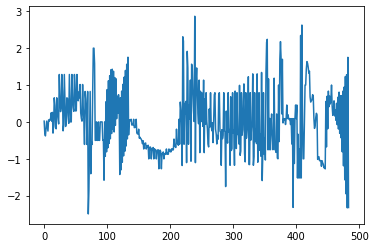

In [71]:
plt.plot(goals_values_i_up['France'].loc['3'])
plt.show()

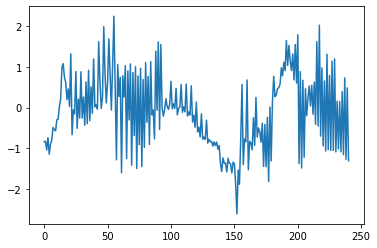

In [75]:
plt.plot(goals_values_i_up['France'].loc['9'])
plt.show()

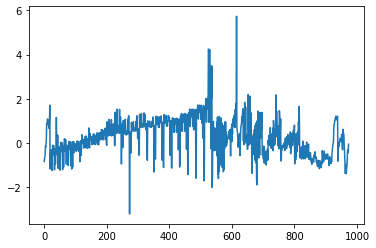

In [74]:
plt.plot(goals_values_i_up['France'].loc['17'])
plt.show()

In [76]:
continents_prep_g = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_g.pkl', 'rb'))
continents_prep_g_K = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/continents_prep_g_K.pkl', 'rb'))

In [95]:
continents_prep_g_K['Europe'][9]

array([[1.        , 0.16557374, 0.19263555, ..., 0.22745702, 0.20045142,
        0.11475323],
       [0.16557374, 1.        , 0.71270179, ..., 0.80197638, 0.73993337,
        0.42561072],
       [0.19263555, 0.71270179, 1.        , ..., 0.89005462, 0.77529178,
        0.51211878],
       ...,
       [0.22745702, 0.80197638, 0.89005462, ..., 1.        , 0.92097416,
        0.55541918],
       [0.20045142, 0.73993337, 0.77529178, ..., 0.92097416, 1.        ,
        0.58401908],
       [0.11475323, 0.42561072, 0.51211878, ..., 0.55541918, 0.58401908,
        1.        ]])

In [94]:
np.exp(-(1/14)**2*np.linalg.norm(continents_prep_g['Europe'][8][0,:]-continents_prep_g['Europe'][8][1,:])**2)

0.3513490516735994

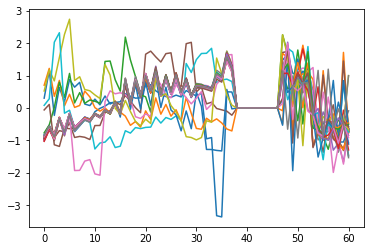

In [96]:
plt.plot(continents_prep_g['Europe'][9].T)
plt.show()

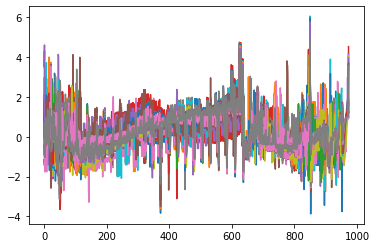

In [85]:
plt.plot(continents_prep_g['Europe'][16].T)
plt.show()